In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchkeras
from plotly import graph_objects as go
from sklearn.preprocessing import MinMaxScaler

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

import matplotlib as mpl
from matplotlib import cm

# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os
os.mkdir('results', exist_ok=True)

# 1.读取数据

In [ ]:
data = np.load(r'ningxia-mod13a2_2011-2020.npy')
print(data.min(), data.max())
(W, H) = data.shape[1], data.shape[2]

-27520 9653


In [3]:
# 预处理
x, y, z = np.where(data<-3000)
for xx, yy, zz in zip(x, y, z):
    data[x,y,z]=-3000

print(data.min(), data.max())

-3000 9653


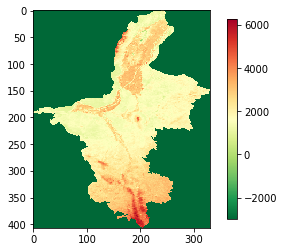

In [4]:
# 可视化
plt.imshow(data.mean(axis=0), interpolation='nearest', cmap='RdYlGn_r')
plt.colorbar(shrink=.92)

# 2.POD分解

In [5]:
def POD_svd(X):
    '''
    input:
        X : m*n matrix with m features and n snapshot after 中心化
    return:
        k+1 : 累计方差99.5%的特征值个数
        u[:, :k+1] ： 对应特征向量 u[:,i]
        s[:k+1] ： 对应奇异值列表
        vh[:k+1, :] : 时间系数矩阵 vh[i,:]
    '''
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    # s = s**2 / X.shape[1]
    s1 = s**2 / X.shape[1]
    C_per = np.cumsum(s1) / s1.sum()
    # 求累计99.5%的下标
    k = 0
    for i in range(len(C_per)):
        if C_per[i] > 0.995:
            k = i
            print(C_per[i])
            break
    return k+1, u[:, :k+1], s[:k+1], vh[:k+1, :], C_per

In [6]:
# 定义预测步长
num_predict = 20

In [7]:
# POD分解
XX = data.reshape(data.shape[0], (W*H)).T
XX_mean = np.mean(XX, axis=1, keepdims=True)
XX = XX - XX_mean
print(XX.shape)
k, u, s, vh, s_per = POD_svd(XX[:, :-num_predict])
A = vh.T
k, u.shape, s.shape, A.shape

(134717, 230)
0.9953948379841014


(24, (134717, 24), (24,), (210, 24))

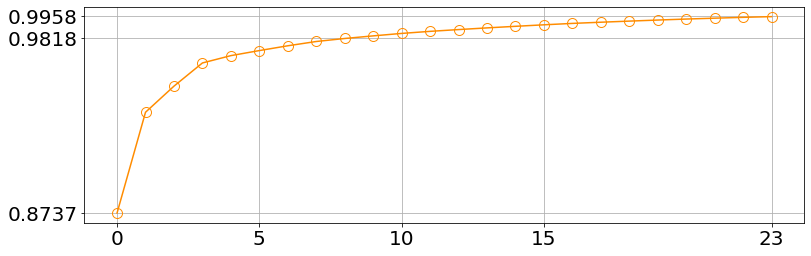

In [8]:
# 保存累计方差贡献率图
plt.figure(figsize=(10,3))
plt.plot(s_per[:k], marker='o', color='darkorange',markersize=10,markerfacecolor='none') 
plt.grid(True)
plt.tick_params(labelsize=20)
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.xticks([i*5 for i in range(k // 5)] + [k-1])
plt.yticks([s_per[0], s_per[k // 3], s_per[k]])
plt.savefig(f'results/result_feature_values_plot.png', dpi=300, bbox_inches='tight')

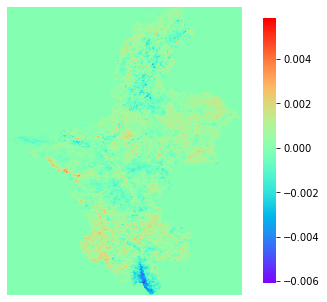

In [9]:
# 保存空间模态均值
plt.imshow(np.mean(u[:,:], axis=1, keepdims=True).reshape(W,H), cmap='rainbow')
plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
cbar = plt.colorbar(shrink=.92, pad=0.05)
cbar.outline.set_visible(False)
plt.savefig(f'results/result_spatial_mode_avg.png', dpi=300, bbox_inches='tight')

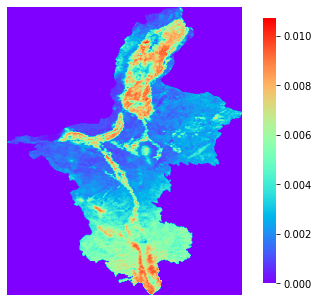

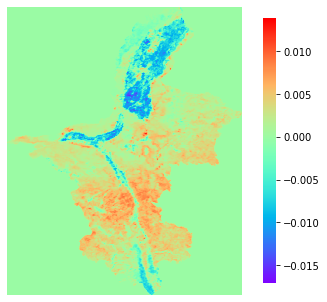

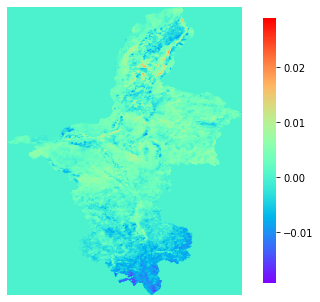

In [10]:
# 保存前三个空间模态
for idx in range(3):
    # idx=2
    plt.figure()
    plt.imshow(u[:,idx].reshape(W,H), cmap='rainbow')
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    cbar = plt.colorbar(shrink=.92, pad=0.05)
    cbar.outline.set_visible(False)
    plt.savefig(f'results/result_spatial_mode_{idx}.png', dpi=300, bbox_inches='tight')

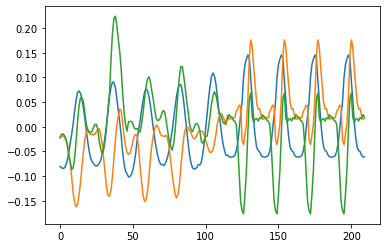

In [11]:
# 可视化前三个空间模态对应的时间系数序列
plt.plot(vh[0,:])
plt.plot(vh[1,:])
plt.plot(vh[2,:])

# 3.时间系数预测

In [12]:
# 参数
feature_size = A.shape[1]
hidden_size = 256
num_layers = 2
output_size = feature_size
epochs = 500
lr = 1e-3
time_step = 10

In [13]:
# 预定义函数
# 数据集划分
def create_dataset(data:list, time_step: int, num_predict: int):
    arr_x, arr_y = [], []
    for i in range(len(data) - num_predict - time_step + 1):
        x = data[i: i + time_step, :]
        y = data[i + time_step + num_predict - 1, :]
        # print(i+time_step)
        arr_x.append(x)
        arr_y.append(y)
    return np.array(arr_x), np.array(arr_y)

# 定义GRU网络
class Net(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, output_size):
        super(Net, self).__init__()
        self.hidden_size = hidden_size  # 隐层大小
        self.num_layers = num_layers  # gru层数
        # feature_size为特征维度，就是每个时间点对应的特征数量
        self.gru = nn.GRU(feature_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        x = x.to(device)
        batch_size = x.shape[0] # 获取批次大小

        # 初始化隐层状态
        if hidden is None:
            h_0 = x.data.new(self.num_layers, batch_size, self.hidden_size).fill_(0).float().to(device)
        else:
            h_0 = hidden.to(device)
        

        # GRU运算
        output, h_0 = self.gru(x, h_0)

        # 获取GRU输出的维度信息
        batch_size, timestep, hidden_size = output.shape

        # 将output变成 batch_size * timestep, hidden_dim
        output = output.reshape(-1, hidden_size)

        # 全连接层
        output = self.fc(output)  # 形状为batch_size * timestep, 1

        # 转换维度，用于输出
        output = output.reshape(timestep, batch_size, -1)

        # 我们只需要返回最后一个时间片的数据即可
        return output[-1].unsqueeze(1)


In [14]:
# 数据预览,第一个时间系数序列
fig = go.Figure()
fig.add_trace(go.Scatter(x=[i for i in range(A.shape[0])], y=A[:,0]))
fig.show()

In [15]:
# 数据处理
# 归一化 [0, 1]
scaler = MinMaxScaler()
predict_field = 'Scaler'
df = scaler.fit_transform(A)
df.min(), df.max()

(0.0, 1.0)

In [16]:
# 划分dataset
X, Y = create_dataset(df, time_step, num_predict)

# 转化成 tensor->(batch_size, seq_len, feature_size)
X = torch.tensor(X, dtype=torch.float).to(device)
Y = torch.tensor(Y, dtype=torch.float).unsqueeze(1).to(device)
print('Total datasets: ', X.shape, '-->', Y.shape)

# 划分数据
split_ratio = 0.9
len_train = int(X.shape[0] * split_ratio)
X_train, Y_train = X[:len_train, :, :], Y[:len_train, :, :]
print('Train datasets: ', X_train.shape, '-->', Y_train.shape)
X_test, Y_test = X[len_train:, :, :], Y[len_train:, :, :]
print('Test datasets: ', X_test.shape, '-->', Y_test.shape)

Total datasets:  torch.Size([181, 10, 24]) --> torch.Size([181, 1, 24])
Train datasets:  torch.Size([162, 10, 24]) --> torch.Size([162, 1, 24])
Test datasets:  torch.Size([19, 10, 24]) --> torch.Size([19, 1, 24])


In [17]:
# 构建迭代器
batch_size = 10
ds = TensorDataset(X, Y)
dl = DataLoader(ds, batch_size=batch_size, num_workers=0)
ds_train = TensorDataset(X_train, Y_train)
dl_train = DataLoader(ds_train, batch_size=batch_size, num_workers=0)
# 查看第一个batch
x, y = next(iter(dl_train))
print(x.shape)
print(y.shape)

batch_size = 10
ds_test = TensorDataset(X_test, Y_test)
dl_test = DataLoader(ds_test, batch_size=batch_size, num_workers=0)
x, y = next(iter(dl_test))
print(x.shape)
print(y.shape)

torch.Size([10, 10, 24])
torch.Size([10, 1, 24])
torch.Size([10, 10, 24])
torch.Size([10, 1, 24])


In [18]:
# torchkeras API 训练方式
model = torchkeras.Model(Net(feature_size, hidden_size, num_layers, output_size).to(device))
model.summary(input_shape=(time_step, feature_size))
model.compile(loss_func=F.mse_loss, optimizer=torch.optim.Adam(model.parameters(), lr=lr), device=device)
dfhistory = model.fit(epochs=epochs, dl_train=dl_train, log_step_freq=20, dl_val=dl_test)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1              [-1, 10, 256]         611,328
            Linear-2                   [-1, 24]           6,168
Total params: 617,496
Trainable params: 617,496
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.000916
Forward/backward pass size (MB): 0.019714
Params size (MB): 2.355560
Estimated Total Size (MB): 2.376190
----------------------------------------------------------------
Start Training ...

================================================================================2025-04-10 11:07:22

 +-------+------+----------+
| epoch | loss | val_loss |
+-------+------+----------+
|   1   | 0.11 |  0.055   |
+-------+------+----------+

================================================================================2025-04-10 11:07:23

 +-------+-------+----------+
| epoch |  loss 

In [19]:
# 模型评估
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfhistory.index, y=dfhistory['loss'], name='loss'))
fig.add_trace(go.Scatter(x=dfhistory.index, y=dfhistory['val_loss'], name='val loss'))
fig.show()

In [20]:
# 预测验证预览
y_true = Y.cpu().numpy().squeeze()
y_pred = model.predict(dl).detach().cpu().numpy().squeeze()

fig = go.Figure()
fig.add_trace(go.Scatter(y=y_true[:, 0], name='y_true'))
fig.add_trace(go.Scatter(y=y_pred[:, 0], name='y_pred'))
fig.show()

In [21]:
# 向后滚动预测时间系数
y_pred = []

print(df.shape)
for i in range(df.shape[0]-time_step-num_predict, df.shape[0] - time_step):
    print(i,i+time_step)
    x_pred = [[torch.tensor(df[i:i+time_step,:], dtype=torch.float32).unsqueeze(0), torch.tensor(df[-1,:]).unsqueeze(0)]]
    print(x_pred[0][0].shape)
    output = model.predict(x_pred)
    # print(output.shape)
    y_pred.append(output.detach().cpu().numpy().squeeze())

(210, 24)
180 190
torch.Size([1, 10, 24])
181 191
torch.Size([1, 10, 24])
182 192
torch.Size([1, 10, 24])
183 193
torch.Size([1, 10, 24])
184 194
torch.Size([1, 10, 24])
185 195
torch.Size([1, 10, 24])
186 196
torch.Size([1, 10, 24])
187 197
torch.Size([1, 10, 24])
188 198
torch.Size([1, 10, 24])
189 199
torch.Size([1, 10, 24])
190 200
torch.Size([1, 10, 24])
191 201
torch.Size([1, 10, 24])
192 202
torch.Size([1, 10, 24])
193 203
torch.Size([1, 10, 24])
194 204
torch.Size([1, 10, 24])
195 205
torch.Size([1, 10, 24])
196 206
torch.Size([1, 10, 24])
197 207
torch.Size([1, 10, 24])
198 208
torch.Size([1, 10, 24])
199 209
torch.Size([1, 10, 24])


In [22]:
# 反归一化预测结果
print(len(y_pred), y_pred[0].shape)
A_pred = scaler.inverse_transform(np.array(y_pred))
A_pred.shape

20 (24,)


(20, 24)

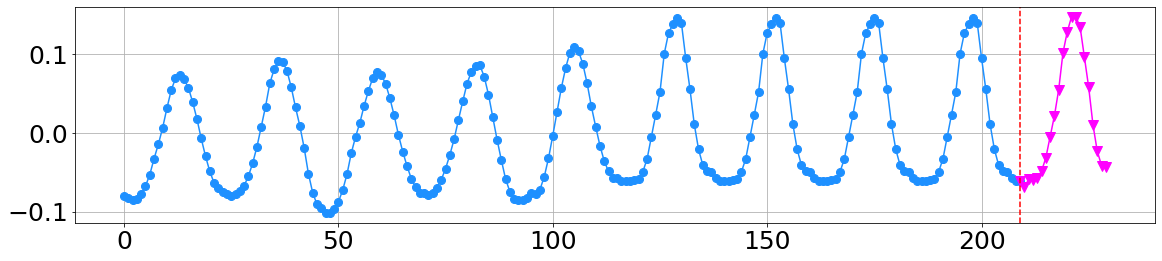

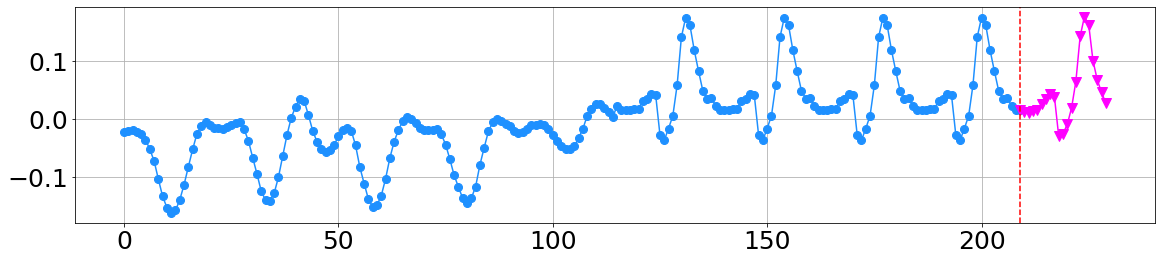

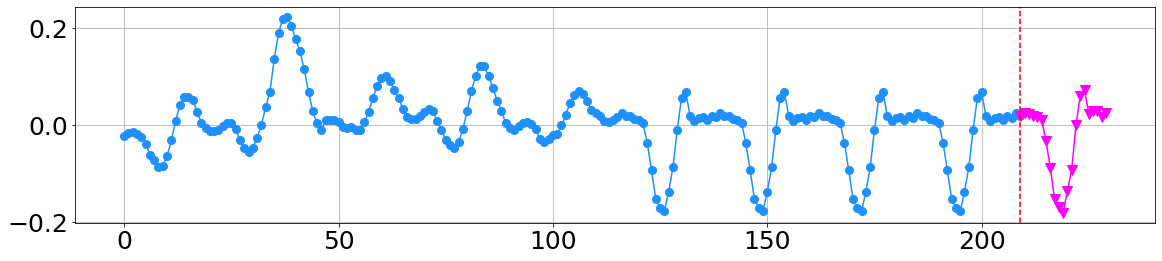

In [23]:
# 可视化前三个时间系数序列的预测结果
for i in range(3):
    # i = 2
    plt.figure(figsize=(15,3))
    plt.plot(range(A.shape[0]), A[:,i], marker='o', color='dodgerblue',markersize=8) 
    plt.plot(range(A.shape[0]-1, A.shape[0]+A_pred.shape[0]), np.concatenate([A[-1:,:], A_pred], axis=0)[:,i], marker='v', color='fuchsia', markersize=10)
    plt.grid(True)
    plt.tick_params(labelsize=25)
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.axvline(A.shape[0]-1, color='r', linestyle='--')
    plt.savefig(f'results/result_time_coeff_series_pred_{i+1}.png', dpi=300, bbox_inches='tight')

# 4.合成未来图像

In [24]:
data_pred_list = []

for i in range(A_pred.shape[0]):

    img_pred = np.dot(u*s, A_pred[i])
    img_pred = img_pred.reshape(W, H)
    
    data_pred_list.append(img_pred)

data_pred = np.array(data_pred_list)
data_pred.shape

(20, 407, 331)

# 5.结果评价

In [25]:
data_true = data[-num_predict:, :, :].astype(np.float32)
# 反中心化
data_pred = data_pred + XX_mean.reshape(W, H)

data_min, data_max = min(data_true.min(), data_pred.min()), max(data_true.max(), data_pred.max())
print(data_min, data_max)
data_true = (data_true - data_min) / (data_max - data_min)
data_pred = (data_pred - data_min) / (data_max - data_min)

# 计算ssim, psnr, mse
ssim_list = []
psnr_list = []
mse_list = []
for i in range(len(data_pred_list)):
    img_true, img_pred = data_true[i], data_pred[i]
    ssim_list.append(ssim(img_true, img_pred, data_range=1.0))
    psnr_list.append(psnr(img_true, img_pred, data_range=1.))
    mse_list.append(mse(img_true, img_pred))

# 计算平均值
avg_ssim = np.mean(ssim_list)
avg_psnr = np.mean(psnr_list)
avg_mse = np.mean(mse_list)

print(f'num_layers: {num_layers}')
print(f'time_step: {time_step}')
print(f'num_predict: {num_predict}')
# 打印结果
print("Average SSIM: {:.4f}".format(avg_ssim))
print("Average PSNR: {:.2f} dB".format(avg_psnr))
print("Average MSE: {:.6f}".format(avg_mse))

-3000.0000000001387 9163.0672984968
num_layers: 2
time_step: 10
num_predict: 20
Average SSIM: 0.9654
Average PSNR: 35.05 dB
Average MSE: 0.000623


In [26]:
# 保存POD预测结果

data_true = data_true * (data_max - data_min) + data_min
data_pred = data_pred * (data_max - data_min) + data_min

np.save(f'result_array.npy', data_pred)


for i in range(len(data_pred_list)):
    plt.figure()
    plt.imshow(data_true[i], cmap="gist_earth_r")    # Spectral
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    cbar = plt.colorbar(shrink=.92)
    cbar.outline.set_visible(False)
    plt.axis('off')
    plt.savefig(f'results/result_img_{i+1}_true.png', dpi=300, bbox_inches='tight')
    plt.close()


    norm = mpl.colors.Normalize(vmin=data_true[i].min(), vmax=data_true[i].max())
    plt.figure()
    plt.imshow(data_pred[i], cmap="gist_earth_r", norm=norm)    # Spectral
    plt.axis('off')
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
    plt.margins(0, 0)
    cbar = plt.colorbar(shrink=.92)
    cbar.outline.set_visible(False)
    plt.axis('off')
    plt.savefig(f'results/result_img_{i+1}_pred.png', dpi=300, bbox_inches='tight')
    plt.close()